In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from Utils.dataset import PreloadedDataset
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
from sklearn.metrics import accuracy_score

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else "cpu"
# device = torch.device('cpu')
device

device(type='cuda')

Loaded MNIST with 48000 samples


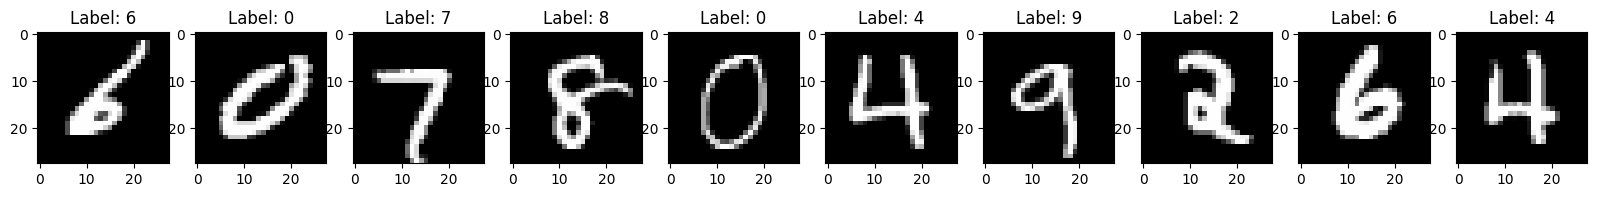

In [32]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

raw_dataset = datasets.MNIST(root="../Datasets/", train=True, transform=transform, download=True)

VAL_RATIO = 0.2
n_val = int(len(raw_dataset) * VAL_RATIO)
n_train = len(raw_dataset) - n_val
train_dataset, val_dataset = torch.utils.data.random_split(raw_dataset, [n_train, n_val])

train_dataset = PreloadedDataset.from_dataset(train_dataset, None, device)
val_dataset = PreloadedDataset.from_dataset(val_dataset, None, device)

print(f'Loaded MNIST with {len(train_dataset)} samples')
# show first samples
fig, axs = plt.subplots(1,10, figsize=(20, 4))
for i in range(10):
    axs[i].imshow(train_dataset[i][0].cpu().permute(1, 2, 0), cmap='gray')
    axs[i].set_title(f"Label: {train_dataset[i][1]}")
plt.show()

In [34]:
def evaluate(
    model,
    dataloader,
    criterion,
):
    total_loss = 0
    total_correct = 0

    for batch, (images, targets) in enumerate(dataloader):
        images = images.flatten(start_dim=1)

        out = model(images)
        loss = criterion(out, targets)

        total_loss += loss.item()
        total_correct += (out.argmax(dim=1) == targets).sum().item()

    return total_loss / len(dataloader), total_correct / len(dataloader.dataset)


def train(
    model,
    optimiser,
    criterion,
    train_dataloader,
    val_dataloader,
    epochs=20,
    stats=None,
):
    if stats is None:
        stats = {
            "train_loss": [],
            "train_acc": [],
            "val_loss": [],
            "val_acc": [],
        }

    for epoch in range(epochs):
        loop = tqdm(train_dataloader, leave=False, total=len(train_dataloader))
        if epoch > 0:
            loop.set_description(f"Epoch {epoch}/{epochs}")
            loop.set_postfix(t_loss=stats["train_loss"][-1], v_loss=stats["val_loss"][-1], t_acc=stats["train_acc"][-1], v_acc=stats["val_acc"][-1])

        total_loss = 0
        total_correct = 0

        for batch, (images, targets) in enumerate(loop):
            images = images.flatten(start_dim=1)

            out = model(images)
            loss = criterion(out, targets)

            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            total_loss += loss.item()
            total_correct += (out.argmax(dim=1) == targets).sum().item()

        stats["train_loss"].append(total_loss / len(train_dataloader))
        stats["train_acc"].append(total_correct / len(train_dataloader.dataset))
        
        val_loss, val_acc = evaluate(model, val_dataloader, criterion)
        stats["val_loss"].append(val_loss)
        stats["val_acc"].append(val_acc)

    return stats

In [47]:
class MNISTConvNet(nn.Module):
    def __init__(self):
        super(MNISTFeedforward, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x

model = MNISTFeedforward().to(device)
stats = None

In [48]:
BATCH_SIZE=256
EPOCHS=30
LR = 0.001

optimiser = torch.optim.AdamW(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

stats = train(
    model,
    optimiser,
    criterion,
    train_dataloader,
    val_dataloader,
    EPOCHS,
    stats,
)

Best validation error: 2.73%


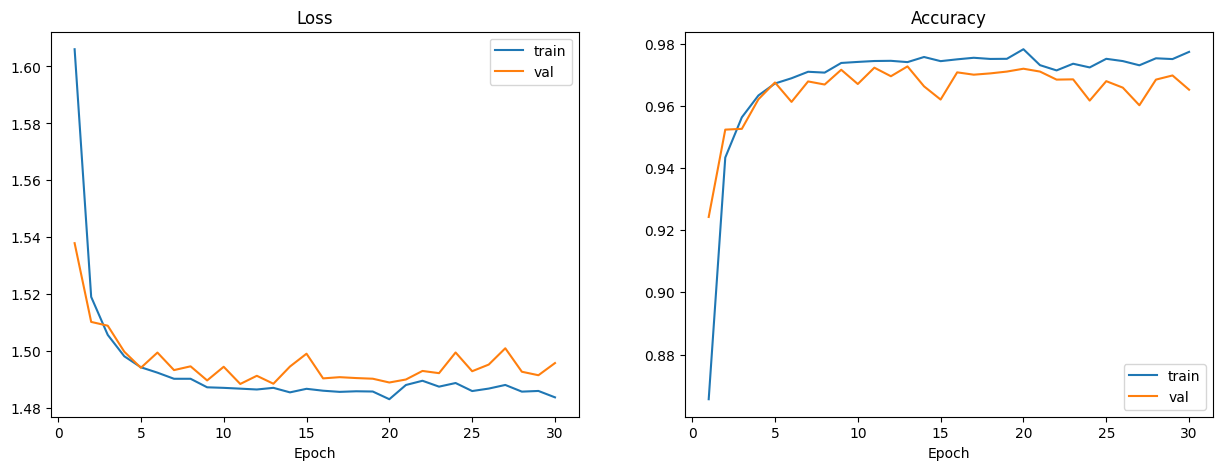

In [49]:
# Plotting
import numpy as np
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(np.arange(1, len(stats["train_loss"])+1), stats["train_loss"], label="train")
axs[0].plot(np.arange(1, len(stats["val_loss"])+1), stats["val_loss"], label="val")
axs[0].legend()
axs[0].set_title("Loss")
axs[0].set_xlabel("Epoch")
axs[1].plot(np.arange(1, len(stats["train_acc"])+1), stats["train_acc"], label="train")
axs[1].plot(np.arange(1, len(stats["val_acc"])+1), stats["val_acc"], label="val")
axs[1].legend()
axs[1].set_title("Accuracy")
axs[1].set_xlabel("Epoch")

print(f"Best validation error: {100 - max(stats['val_acc']) * 100:.2f}%")
plt.show()

In [50]:
test_dataset = datasets.MNIST(root="../Datasets/", train=False, transform=transform, download=True)
test_dataset = PreloadedDataset.from_dataset(test_dataset, None, device)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}, Test Error: {100-test_acc*100:.4f}%")

Test Loss: 1.4940, Test Accuracy: 0.9668, Test Error: 3.3200%
